In [ ]:
# Train a machine learning model to predict future machine failures using sensor data

In [ ]:
#import the necessary libraries

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

#creating the folders and confirming for data, merged files, and models
os.makedirs("/content/data", exist_ok=True)
os.makedirs("/content/merged", exist_ok=True)
os.makedirs("/content/models", exist_ok=True)
print("Folders ready!")

Folders ready!


In [ ]:
import glob
#Checking for csv files in the data directory

DATA_DIR = "/content/data"
csv_files = glob.glob(f"{DATA_DIR}/*.csv")

print("CSV files found:", csv_files)

CSV files found: ['/content/data/humidity_data.csv', '/content/data/vibration_data.csv', '/content/data/temperature_data.csv', '/content/data/annotations.csv', '/content/data/pressure_data.csv', '/content/data/plc_logs.csv']


In [ ]:
import os
#Files are inside the folders. Print the list of files to confirm.

print("Files inside /content/data:")
print(os.listdir("/content/data"))

Files inside /content/data:
['humidity_data.csv', 'vibration_data.csv', 'data_dictionary.xlsx', 'temperature_data.csv', 'annotations.csv', 'pressure_data.csv', 'plc_logs.csv']


In [ ]:
from google.colab import files
uploaded = files.upload() #uploding the csv files from local machine to Colab environment

Saving annotations.csv to annotations.csv
Saving data_dictionary.xlsx to data_dictionary.xlsx
Saving humidity_data.csv to humidity_data.csv
Saving plc_logs.csv to plc_logs.csv
Saving pressure_data.csv to pressure_data.csv
Saving temperature_data.csv to temperature_data.csv
Saving vibration_data.csv to vibration_data.csv


In [ ]:
import os
import shutil

os.makedirs("/content/data", exist_ok=True)

# Move uploaded files to the '/content/data' directory
for fname in uploaded.keys():
    shutil.move(fname, "/content/data/" + fname)

print("Files inside /content/data:")
print(os.listdir("/content/data"))

Files inside /content/data:
['humidity_data.csv', 'vibration_data.csv', 'data_dictionary.xlsx', 'temperature_data.csv', 'annotations.csv', 'pressure_data.csv', 'plc_logs.csv']


In [ ]:
import glob

DATA_DIR = "/content/data"
csv_files = glob.glob(f"{DATA_DIR}/*.csv")

print("All CSV files:", csv_files)
#all csv files are found

All CSV files: ['/content/data/humidity_data.csv', '/content/data/vibration_data.csv', '/content/data/temperature_data.csv', '/content/data/annotations.csv', '/content/data/pressure_data.csv', '/content/data/plc_logs.csv']


In [ ]:
annotation_candidates = []

# Iterate through each CSV file to find the annotation file
for f in csv_files:
    df_tmp = pd.read_csv(f)
    cols = df_tmp.columns.str.lower().tolist()

    # The annotation file contains "machine_status" column
    if "machine_status" in cols:
        annotation_candidates.append(f)

# Raise an error if no annotation file is found
if len(annotation_candidates) == 0:
    raise FileNotFoundError("No annotation CSV containing 'machine_status' found.")

# Select the first candidate as the annotation file
annotation_file = annotation_candidates[0]
print("Annotation file detected:", annotation_file)

pd.read_csv("/content/data/annotations.csv").head() # Display the first few rows of the annotation file

Annotation file detected: /content/data/annotations.csv


,timestamp,machine_status
0,2025-06-01 00:00:00,normal
1,2025-06-01 00:10:00,normal
2,2025-06-01 00:20:00,normal
3,2025-06-01 00:30:00,normal
4,2025-06-01 00:40:00,warning


In [ ]:
pd.read_csv("/content/data/plc_logs.csv").head() # Display the first few rows of plc logs, skipping this csv file because it does not have sensor id

,timestamp,action,actuator,response_code
0,2025-06-01 00:00:00,start_heating,B2,OK
1,2025-06-01 00:10:00,stop_cooling,C3,OK
2,2025-06-01 00:20:00,start_cooling,C3,OK
3,2025-06-01 00:30:00,start_heating,C3,OK
4,2025-06-01 00:40:00,start_cooling,B2,OK


In [ ]:
pd.read_csv("/content/data/temperature_data.csv").head() # Display the first few rows of temperature data

,timestamp,sensor_id,value,unit
0,2025-06-01 00:00:00,TEMPERATURE001,39.9513,°C
1,2025-06-01 00:10:00,TEMPERATURE001,40.0020,°C
2,2025-06-01 00:20:00,TEMPERATURE001,40.0427,°C
3,2025-06-01 00:30:00,TEMPERATURE001,39.9508,°C
4,2025-06-01 00:40:00,TEMPERATURE001,40.0144,°C


In [ ]:
pd.read_csv("/content/data/pressure_data.csv").head() # Display the first few rows of pressure data

,timestamp,sensor_id,value,unit
0,2025-06-01 00:00:00,PRESSURE001,101324.9695,Pa
1,2025-06-01 00:10:00,PRESSURE001,101324.9182,Pa
2,2025-06-01 00:20:00,PRESSURE001,101325.0419,Pa
3,2025-06-01 00:30:00,PRESSURE001,101324.9259,Pa
4,2025-06-01 00:40:00,PRESSURE001,101325.0878,Pa


In [ ]:
pd.read_csv("/content/data/humidity_data.csv").head() # Display the first few rows of humidity data

,timestamp,sensor_id,value,unit
0,2025-06-01 00:00:00,HUMIDITY001,54.9038,%
1,2025-06-01 00:10:00,HUMIDITY001,54.9135,%
2,2025-06-01 00:20:00,HUMIDITY001,55.0373,%
3,2025-06-01 00:30:00,HUMIDITY001,55.1411,%
4,2025-06-01 00:40:00,HUMIDITY001,55.1453,%


In [ ]:
pd.read_csv("/content/data/vibration_data.csv").head() # Display the first few rows of vibration data

,timestamp,sensor_id,value,unit
0,2025-06-01 00:00:00,VIBRATION001,0.0002,g
1,2025-06-01 00:10:00,VIBRATION001,-0.2659,g
2,2025-06-01 00:20:00,VIBRATION001,0.1336,g
3,2025-06-01 00:30:00,VIBRATION001,0.0617,g
4,2025-06-01 00:40:00,VIBRATION001,-0.0964,g


In [ ]:
sensor_files = []

# Iterate through all CSV files to identify sensor data files
for f in csv_files:
    # Skip the annotation file as it's not sensor data
    if f == annotation_file:
        continue

    df = pd.read_csv(f)

    # A sensor file must contain a "sensor_id" column
    if "sensor_id" not in df.columns:
        print("Skipping non-sensor file:", f)
        continue

    sensor_files.append(f)

print("Sensor files:", sensor_files)

Skipping non-sensor file: /content/data/plc_logs.csv
Sensor files: ['/content/data/humidity_data.csv', '/content/data/vibration_data.csv', '/content/data/temperature_data.csv', '/content/data/pressure_data.csv']


In [ ]:
sensor_map = {
    "vibration": "VIBRATION",
    "humidity": "HUMIDITY",
    "pressure": "PRESSURE",
    "temperature": "TEMPERATURE"
}

dfs = []

# Process each sensor file
for f in sensor_files:
    df = pd.read_csv(f)
    df['timestamp'] = pd.to_datetime(df['timestamp']) # Convert timestamp to datetime objects

    # Ensure the file has a 'sensor_id' column
    if "sensor_id" not in df.columns:
        print("Skipping non-sensor file (no sensor_id):", f)
        continue

    sid = df['sensor_id'].iloc[0].upper() # Get the sensor ID and convert to uppercase
    sensor_name = None

    # Map the sensor ID to a standardized sensor name (e.g., 'vibration')
    for key, match in sensor_map.items():
        if match in sid:
            sensor_name = key
            break

    # Skip if sensor name cannot be determined
    if sensor_name is None:
        print("Skipping unknown sensor:", f)
        continue

    # Select 'timestamp' and 'value' columns, rename 'value' to sensor_name
    df = df[['timestamp', 'value']].rename(columns={'value': sensor_name})
    # Set timestamp as index, resample to 10-minute intervals, take mean, and interpolate missing values
    df = df.set_index("timestamp").resample("10min").mean().interpolate()
    dfs.append(df)

# Concatenate all processed sensor dataframes into a single merged dataframe
merged = pd.concat(dfs, axis=1)
merged.head() # Display the first few rows of the merged sensor data

,humidity,vibration,temperature,pressure
timestamp,,,,
2025-06-01 00:00:00,54.9038,0.0002,39.9513,101324.9695
2025-06-01 00:10:00,54.9135,-0.2659,40.0020,101324.9182
2025-06-01 00:20:00,55.0373,0.1336,40.0427,101325.0419
2025-06-01 00:30:00,55.1411,0.0617,39.9508,101324.9259
2025-06-01 00:40:00,55.1453,-0.0964,40.0144,101325.0878


In [ ]:
#merging all the csv files by joining sensor data with annotations
ann = pd.read_csv("/content/data/annotations.csv")
ann['timestamp'] = pd.to_datetime(ann['timestamp']) # Convert timestamp to datetime
ann = ann.set_index('timestamp') # Set timestamp as index

# Join the merged sensor data with the machine status annotations
merged = merged.join(ann['machine_status'], how='left')
merged = merged.rename(columns={'machine_status': 'fault_type'}) # Rename column for clarity
merged['fault_type'] = merged['fault_type'].fillna("normal") # Fill any missing fault types with 'normal'
merged = merged.reset_index() # Reset index to make timestamp a regular column

# Save the final merged DataFrame to a CSV file
merged.to_csv("/content/merged/merged_multimodal.csv", index=False)
merged.head() # Display the first few rows of the final merged dataframe

,timestamp,humidity,vibration,temperature,pressure,fault_type
0,2025-06-01 00:00:00,54.9038,0.0002,39.9513,101324.9695,normal
1,2025-06-01 00:10:00,54.9135,-0.2659,40.0020,101324.9182,normal
2,2025-06-01 00:20:00,55.0373,0.1336,40.0427,101325.0419,normal
3,2025-06-01 00:30:00,55.1411,0.0617,39.9508,101324.9259,normal
4,2025-06-01 00:40:00,55.1453,-0.0964,40.0144,101325.0878,warning


In [ ]:
print("Original imbalance:") # Print a header for the output
print(merged["fault_type"].value_counts()) # Display the distribution of 'fault_type' values

Original imbalance:
fault_type
normal     121
warning     17
failure      6
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
df = pd.read_csv("/content/merged/merged_multimodal.csv") # Load the merged multimodal dataset
df['timestamp'] = pd.to_datetime(df['timestamp']) # Convert 'timestamp' column to datetime objects
df = df.set_index('timestamp').sort_index() # Set 'timestamp' as index and sort the DataFrame by index

In [ ]:
import pandas as pd
import numpy as np
import joblib # For saving and loading models
import os

from sklearn.model_selection import train_test_split # For splitting data into training and testing sets
from sklearn.preprocessing import LabelEncoder, StandardScaler # For encoding labels and scaling features
from sklearn.ensemble import RandomForestClassifier # The machine learning model
from sklearn.metrics import classification_report, confusion_matrix # For model evaluation metrics
from sklearn.utils.class_weight import compute_class_weight # For handling class imbalance (though 'balanced_subsample' is used directly in RFClassifier)
#import

In [ ]:
# Load merged multimodal dataset
merged = pd.read_csv("/content/merged/merged_multimodal.csv", parse_dates=["timestamp"])

print("Rows:", len(merged)) # Print the number of rows in the dataset
print("Columns:", merged.columns.tolist()) # Print the list of columns

print("\nLabel distribution:") # Print a header for label distribution
print(merged["fault_type"].value_counts()) # Display the counts of each 'fault_type' label

Rows: 144
Columns: ['timestamp', 'humidity', 'vibration', 'temperature', 'pressure', 'fault_type']

Label distribution:
fault_type
normal     121
warning     17
failure      6
Name: count, dtype: int64


In [ ]:
FEATURES = ["vibration", "temperature", "pressure", "humidity"] # Define the list of features to be used

X = merged[FEATURES].values # Extract feature data into a NumPy array
y = merged["fault_type"].values # Extract target variable data into a NumPy array

In [ ]:
le = LabelEncoder() # Initialize the LabelEncoder
y_enc = le.fit_transform(y) # Fit the encoder to the target variable and transform categorical labels to numerical

print("Classes:", le.classes_) # Print the unique classes found by the LabelEncoder

Classes: ['failure' 'normal' 'warning']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
) # Split the data into training and testing sets (80% train, 20% test) with stratification and a fixed random state

In [ ]:
scaler = StandardScaler().fit(X_train) # Initialize StandardScaler and fit it to the training data

X_train_s = scaler.transform(X_train) # Transform the training features
X_test_s  = scaler.transform(X_test) # Transform the testing features

In [ ]:
rf = RandomForestClassifier(
    n_estimators=400, # Number of trees in the forest
    random_state=42,  # Seed for reproducibility
    class_weight="balanced_subsample", # Automatically adjust weights inversely proportional to class frequencies
    n_jobs=-1         # Use all available CPU cores for parallel processing
)

rf.fit(X_train_s, y_train) # Train the Random Forest classifier on the scaled training data

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=400,
                       n_jobs=-1, random_state=42)

In [ ]:
os.makedirs("/content/models", exist_ok=True) # Create the 'models' directory if it doesn't already exist

joblib.dump(rf, "/content/models/rf_model.joblib") # Save the trained Random Forest model
joblib.dump(scaler, "/content/models/rf_scaler.joblib") # Save the fitted StandardScaler
joblib.dump(le, "/content/models/label_encoder.joblib") # Save the fitted LabelEncoder

print("Saved RF model + scaler + label encoder")

Saved RF model + scaler + label encoder


In [ ]:
rf = joblib.load("/content/models/rf_model.joblib") # Load the trained Random Forest model
scaler = joblib.load("/content/models/rf_scaler.joblib") # Load the fitted StandardScaler
le = joblib.load("/content/models/label_encoder.joblib") # Load the fitted LabelEncoder

In [ ]:
base_window = merged[FEATURES].tail(1).values   # Extract the last row of feature data as the base condition for simulation
print("Base condition:\n", base_window)

Base condition:
 [[-1.48300000e-01  4.00340000e+01  1.01325109e+05  5.50023000e+01]]


In [ ]:
BASE_NOISE = 0.01          # Starting noise level for sensor data
DAILY_INCREASE = 0.005     # Rate at which noise increases day by day
NUM_MACHINES = 200         # Number of parallel machines to simulate
DAYS = 10                  # Number of days to simulate the future

results = [] # Initialize an empty list to store simulation results

In [ ]:
forecast_df = pd.DataFrame(results) # Create an empty DataFrame to store the forecast results
forecast_df

""


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



=== CLASSIFICATION REPORT (RF After SMOTE) ===

              precision    recall  f1-score   support

     failure     1.0000    0.8333    0.9091         6
      normal     0.9600    0.9917    0.9756       121
     warning     0.9286    0.7647    0.8387        17

    accuracy                         0.9583       144
   macro avg     0.9629    0.8633    0.9078       144
weighted avg     0.9580    0.9583    0.9567       144


Confusion Matrix:
 [[  5   1   0]
 [  0 120   1]
 [  0   4  13]]


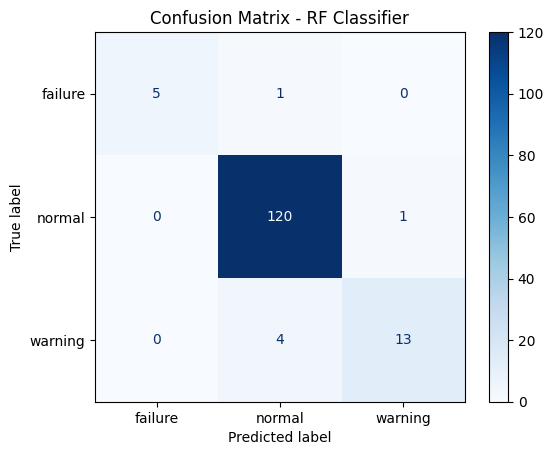

In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define paths for loading saved artifacts
MERGED_CSV = "/content/merged/merged_multimodal.csv"
RF_PATH = "/content/models/rf_model.joblib"
SCALER_PATH = "/content/models/rf_scaler.joblib"
LE_PATH = "/content/models/label_encoder.joblib"

# Load the merged dataset, trained model, scaler, and label encoder
df = pd.read_csv(MERGED_CSV, parse_dates=["timestamp"])
rf = joblib.load(RF_PATH)
scaler = joblib.load(SCALER_PATH)
le = joblib.load(LE_PATH)

# Define features and label columns
FEATURES = ["vibration","temperature","pressure","humidity"]
LABEL = "fault_type"

# Prepare Test Data
X = df[FEATURES] # Extract features
y = le.transform(df[LABEL])  # Encode labels to numerical format

# Scale input features using the loaded scaler
X_scaled = scaler.transform(X)

# Make predictions using the trained Random Forest model
y_pred = rf.predict(X_scaled)

# Generate and print the classification report
print("\n=== CLASSIFICATION REPORT (RF After SMOTE) ===\n")
print(classification_report(y, y_pred, target_names=le.classes_, digits=4))

# Generate and print the confusion matrix
cm = confusion_matrix(y, y_pred)
print("\nConfusion Matrix:\n", cm)

# Plot the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - RF Classifier") # Set plot title
plt.show() # Display the plot

In [ ]:
# Define file paths for loading artifacts
MERGED_CSV = "/content/merged/merged_multimodal.csv"
RF_PATH    = "/content/models/rf_model.joblib"
SCALER_PATH= "/content/models/rf_scaler.joblib"
LE_PATH    = "/content/models/label_encoder.joblib"

# Load merged data, Random Forest model, and scaler
merged = pd.read_csv(MERGED_CSV, parse_dates=["timestamp"])
rf     = joblib.load(RF_PATH)
rf_scaler = joblib.load(SCALER_PATH)

# Load LabelEncoder, with a fallback to recreate if corrupted
try:
    le = joblib.load(LE_PATH)
except KeyError:
    # If label encoder file is corrupted, recreate and re-save it
    print("Warning: label_encoder.joblib file corrupted. Recreating and re-saving LabelEncoder.")
    y = merged["fault_type"].values
    le = LabelEncoder()
    le.fit_transform(y)
    joblib.dump(le, LE_PATH)

FEATURES = ["vibration","temperature","pressure","humidity"] # Define features for the model

# Simulation parameters
NUM_MACHINES = 200 # Number of machines to simulate
DAYS = 10 # Number of days for the simulation forecast
RANDOM_SEED = 42 # Seed for random number generation to ensure reproducibility
np.random.seed(RANDOM_SEED)

K_FOR_BASE = 12 # Number of recent data points to use for base conditions
base_rows = merged[FEATURES].tail(K_FOR_BASE).values   # Get the last K_FOR_BASE rows of feature data

# Standard deviations for adding noise to each feature
FEATURE_NOISE_STD = {
    "vibration": 0.02,
    "temperature": 0.005,
    "pressure": 0.0002,
    "humidity": 0.005
}

USE_STRATEGIES = ["small_noise", "drift", "sample_from_failure"] # Strategies to apply during simulation

DAILY_DRIFT = { "temperature": 0.05, "vibration": 0.005 }  # Additive drift per day for certain features

SAMPLE_FAILURE_P = 0.1 # Probability of sampling a failure-like condition

# Extract historical failure data for sampling
failure_rows = merged[merged["fault_type"].astype(str).str.lower()=="failure"][FEATURES].values

PROB_THRESHOLD_FOR_FAILURE = 0.2 # Probability threshold to classify a machine as 'predicted to fail'

# Function to create noisy samples
def create_noisy_sample(base_row, noise_scale_factor=1.0, day_idx=1, strategy_weights=None):
    row = base_row.copy()
    for i, f in enumerate(FEATURES):
        std = FEATURE_NOISE_STD[f] * noise_scale_factor
        if f == "pressure": # Apply relative noise to pressure
            std = std * base_row[i]
        row[i] = row[i] + np.random.normal(0, std) # Add Gaussian noise
    return row

# Function to apply daily drift
def apply_drift(row, day):
    for i,f in enumerate(FEATURES):
        if f in DAILY_DRIFT:
            row[i] = row[i] + DAILY_DRIFT[f] * day # Add daily drift
    return row

# Safe scaling function to avoid UserWarning
def safe_scale(X_np):
    return rf_scaler.transform(X_np)

# Determine the numerical label for 'failure' class from the LabelEncoder
failure_idx = None
for idx, lab in enumerate(le.classes_):
    if str(lab).lower() == "failure":
        failure_idx = idx
        break
if failure_idx is None:
    print("Warning: label encoder does not contain 'failure' class. Results will not include failures.")

# Simulation loop
rows = []
for day in range(1, DAYS+1):
    day_probs = [] # Store failure probabilities for the current day
    day_hard = [] # Store hard predictions (0 or 1) for the current day

    for m in range(NUM_MACHINES):
        # Randomly select a base row from the recent historical data
        base = base_rows[np.random.randint(0, len(base_rows))].reshape(1,-1)[0]

        # Apply 'sample_from_failure' strategy with a certain probability
        if "sample_from_failure" in USE_STRATEGIES and len(failure_rows) > 0 and (np.random.rand() < SAMPLE_FAILURE_P):
            sample = failure_rows[np.random.randint(0, len(failure_rows))].copy()
            sample = sample + np.random.normal(0, 0.01, size=sample.shape)  # Add small jitter to failure samples
        else:
            sample = base.copy()
            if "small_noise" in USE_STRATEGIES:
                noise_factor = 1.0 + 0.2 * day # Increase noise over time
                sample = create_noisy_sample(sample, noise_scale_factor=noise_factor, day_idx=day)
            if "drift" in USE_STRATEGIES:
                sample = apply_drift(sample, day)

        # Scale the simulated sample and make predictions
        scaled = safe_scale(sample.reshape(1,-1))
        probs = rf.predict_proba(scaled)[0] # Get probability estimates for each class
        pred_num = rf.predict(scaled)[0] # Get the predicted class (numerical)
        pred_label = le.inverse_transform([pred_num])[0] # Convert numerical prediction back to label

        # Get the probability of 'failure' class
        fail_prob = probs[failure_idx] if (failure_idx is not None) else 0.0
        day_probs.append(fail_prob)

        # Determine hard prediction based on failure probability threshold
        hard_pred = 1 if (fail_prob >= PROB_THRESHOLD_FOR_FAILURE) else 0
        day_hard.append(hard_pred)

    # Calculate aggregated results for the current day
    hard_count = int(np.sum(day_hard)) # Total machines predicted to fail (hard count)
    expected_failures = float(np.sum(day_probs)) # Sum of failure probabilities (expected failures)
    mean_prob = float(np.mean(day_probs)) # Mean failure probability across all simulated machines

    # Append results for the day
    rows.append({
        "Forecast_Date": (pd.Timestamp.today() + pd.Timedelta(days=day)).date(),
        "Machines_Predicted_to_Fail(hard_count_thresholded_prob)": hard_count,
        "mean_failure_probability": mean_prob
    })

# Create a DataFrame from the simulation results
out_df = pd.DataFrame(rows)
print(out_df) # Display the forecast DataFrame

  Forecast_Date  Machines_Predicted_to_Fail(hard_count_thresholded_prob)  \
0    2025-11-27                                                 45         
1    2025-11-28                                                 20         
2    2025-11-29                                                 18         
3    2025-11-30                                                 24         
4    2025-12-01                                                 17         
5    2025-12-02                                                 14         
6    2025-12-03                                                 15         
7    2025-12-04                                                  9         
8    2025-12-05                                                 19         
9    2025-12-06                                                 16         

   mean_failure_probability  
0                  0.112912  
1                  0.076175  
2                  0.074137  
3                  0.079987  
4            